## A intenção do projeto é criar um chatbot baseado em reviews de filmes para que se possa fazer perguntas e manter uma conversa livre sobre este tema

- link do banco de dados https://www.kaggle.com/Cornell-University/movie-dialog-corpus?select=movie_lines.tsv
- referências
>- https://shanebarker.com/blog/deep-learning-chatbot/
> -https://towardsdatascience.com/how-to-create-a-chatbot-with-python-deep-learning-in-less-than-an-hour-56a063bdfc44

In [1]:
!pip3 install gensim
!pip3 install tensorflow
!pip3 install keras

In [2]:
import string
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
import gensim
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import math
import random

[nltk_data] Downloading package wordnet to /home/douglas/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Opening movie reviews

In [74]:
messages = pd.read_csv('./chatdata/movie_lines_formated.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [75]:
messages.columns = ['msg_line', 'user1_id', 'movie_id', 'user_name', 'msg']

In [76]:
messages.head(10)

,msg_line,user1_id,movie_id,user_name,msg
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.
5,L924,u2,m0,CAMERON,Wow
6,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.
7,L871,u2,m0,CAMERON,No
8,"""""""L870""",u0,m0,BIANCA,"""I'm kidding. You know how sometimes you just..."
9,L869,u0,m0,BIANCA,Like my fear of wearing pastels?


### Cleaning the index of the conversations

In [77]:
def remove_char(txt):
    return re.sub('[^0-9]','', txt)

In [78]:
#leaving just the number of the index, so L872 changes to 872
messages['msg_line_clean'] = [remove_char(msg) for msg in messages['msg_line']]

In [79]:
#change the column type to number
messages['msg_line_clean'] = pd.to_numeric(messages['msg_line_clean'])

In [80]:
messages.sort_values(by=['msg_line_clean'])

,msg_line,user1_id,movie_id,user_name,msg,msg_line_clean
86,L49,u0,m0,BIANCA,Did you change your hair?,49
85,L50,u3,m0,CHASTITY,No.,50
84,L51,u0,m0,BIANCA,You might wanna think about it,51
648,L59,u9,m0,PATRICK,I missed you.,59
647,L60,u8,m0,MISS PERKY,It says here you exposed yourself to a group o...,60
...,...,...,...,...,...,...
304704,L666522,u9034,m616,VEREKER,So far only their scouts. But we have had repo...,666522
304679,L666546,u9027,m616,CHELMSFORD,Splendid site Crealock splendil I want to esta...,666546
304678,L666547,u9029,m616,CREALOCK,Certainly Sin,666547
304696,L666575,u9028,m616,COGHILL,Choose your targets men. That's right Watch th...,666575


In [81]:
#set the column as the index
messages = messages.set_index('msg_line_clean')

In [82]:
messages.head(10)

,msg_line,user1_id,movie_id,user_name,msg
msg_line_clean,,,,,
1045,L1045,u0,m0,BIANCA,They do not!
1044,L1044,u2,m0,CAMERON,They do to!
985,L985,u0,m0,BIANCA,I hope so.
984,L984,u2,m0,CAMERON,She okay?
925,L925,u0,m0,BIANCA,Let's go.
924,L924,u2,m0,CAMERON,Wow
872,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.
871,L871,u2,m0,CAMERON,No
870,"""""""L870""",u0,m0,BIANCA,"""I'm kidding. You know how sometimes you just..."


### Opening conversation sequence

In [83]:
#read the file with the conversation sequence
conv_seq = pd.read_csv('./chatdata/movie_conversations.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [84]:
conv_seq.head(10)

,0,1,2,3
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']
2,u0,u2,m0,['L200' 'L201' 'L202' 'L203']
3,u0,u2,m0,['L204' 'L205' 'L206']
4,u0,u2,m0,['L207' 'L208']
5,u0,u2,m0,['L271' 'L272' 'L273' 'L274' 'L275']
6,u0,u2,m0,['L276' 'L277']
7,u0,u2,m0,['L280' 'L281']
8,u0,u2,m0,['L363' 'L364']
9,u0,u2,m0,['L365' 'L366']


In [85]:
conv_seq.columns = ['user1_id', 'user2_id', 'movie_id', 'sequence']

In [86]:
conv_seq.head(10)

,user1_id,user2_id,movie_id,sequence
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']
2,u0,u2,m0,['L200' 'L201' 'L202' 'L203']
3,u0,u2,m0,['L204' 'L205' 'L206']
4,u0,u2,m0,['L207' 'L208']
5,u0,u2,m0,['L271' 'L272' 'L273' 'L274' 'L275']
6,u0,u2,m0,['L276' 'L277']
7,u0,u2,m0,['L280' 'L281']
8,u0,u2,m0,['L363' 'L364']
9,u0,u2,m0,['L365' 'L366']


### Build conversation sequence

In [87]:
def split_conversation(txt):
    txt_alt = txt.split(' ')
    return txt_alt

In [88]:
def seq_to_list(seq):
    seq_list = [remove_char(s) for s in seq]
    return seq_list

In [89]:
#initializing the msg_2 column
messages['msg_2'] = '-'

In [90]:
def link_conversations(seq_list, df, filter1, filter2):
    i = 0
    while i in range(len(seq_list)):
        if i+1 < len(seq_list):
            next_msg = df.loc[int(seq_list[i+1]), filter1]
            df.at[int(seq_list[i]), filter2] = next_msg
        i+=1

In [91]:
#link each message with its answer
for conv in conv_seq['sequence']:
    #split each sequence by space
    seq = split_conversation(conv)

    #remove the char L from the sequences
    txt_alt = [remove_char(s) for s in seq]

    #use the conversation sequence to build the target answer for each message
    link_conversations(txt_alt, messages, 'msg', 'msg_2')

In [92]:
messages.head(30)

,msg_line,user1_id,movie_id,user_name,msg,msg_2
msg_line_clean,,,,,,
1045,L1045,u0,m0,BIANCA,They do not!,-
1044,L1044,u2,m0,CAMERON,They do to!,They do not!
985,L985,u0,m0,BIANCA,I hope so.,-
984,L984,u2,m0,CAMERON,She okay?,I hope so.
925,L925,u0,m0,BIANCA,Let's go.,-
924,L924,u2,m0,CAMERON,Wow,Let's go.
872,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,-
871,L871,u2,m0,CAMERON,No,Okay -- you're gonna need to learn how to lie.
870,"""""""L870""",u0,m0,BIANCA,"""I'm kidding. You know how sometimes you just...",No


In [93]:
#remove rows with empty answer
msg_with_answer = messages[messages['msg_2'] != '-']

In [94]:
msg_with_answer

,msg_line,user1_id,movie_id,user_name,msg,msg_2
msg_line_clean,,,,,,
1044,L1044,u2,m0,CAMERON,They do to!,They do not!
984,L984,u2,m0,CAMERON,She okay?,I hope so.
924,L924,u2,m0,CAMERON,Wow,Let's go.
871,L871,u2,m0,CAMERON,No,Okay -- you're gonna need to learn how to lie.
870,"""""""L870""",u0,m0,BIANCA,"""I'm kidding. You know how sometimes you just...",No
...,...,...,...,...,...,...
666520,L666520,u9034,m616,VEREKER,Well I assure you Sir I have no desire to crea...,And I assure you you do not In fact I'd be obl...
666371,L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...
666370,L666370,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...


In [95]:
msg_with_answer = msg_with_answer.reset_index()
msg_with_answer

,msg_line_clean,msg_line,user1_id,movie_id,user_name,msg,msg_2
0,1044,L1044,u2,m0,CAMERON,They do to!,They do not!
1,984,L984,u2,m0,CAMERON,She okay?,I hope so.
2,924,L924,u2,m0,CAMERON,Wow,Let's go.
3,871,L871,u2,m0,CAMERON,No,Okay -- you're gonna need to learn how to lie.
4,870,"""""""L870""",u0,m0,BIANCA,"""I'm kidding. You know how sometimes you just...",No
...,...,...,...,...,...,...,...
221611,666520,L666520,u9034,m616,VEREKER,Well I assure you Sir I have no desire to crea...,And I assure you you do not In fact I'd be obl...
221612,666371,L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...
221613,666370,L666370,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...
221614,666369,L666369,u9030,m616,DURNFORD,Your orders Mr Vereker?,I'm to take the Sikali with the main column to...


## Data exploration

In [96]:
users = msg_with_answer['user_name']

### People with more messages sent

In [34]:
from collections import Counter
import seaborn as sns

In [97]:
counter=Counter(users)
most=counter.most_common()

In [98]:
len(most)

5757

<AxesSubplot:>

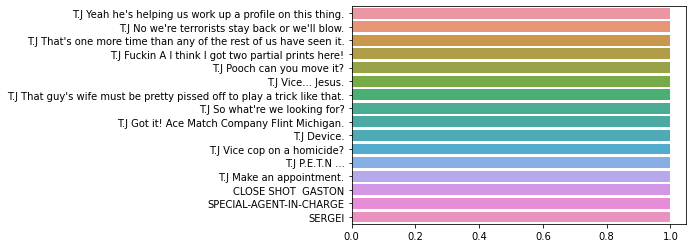

In [99]:
x, y= [], []
for word,count in most[5740:5756]:
    x.append(word)
    y.append(count)
        
sns.barplot(x=y,y=x)

There are some user names concatenated with messages

## Checking the user names concated with messages

In [45]:
user = messages['user_name']

In [48]:
messages['len_user_name'] = [len(str(u)) for u in user]

<AxesSubplot:>

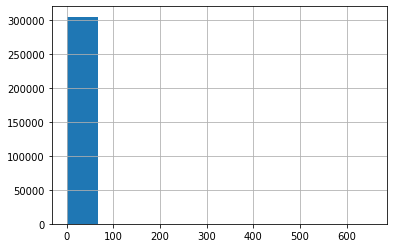

In [50]:
#histogram to display the number of character of each user
user.str.len().hist()

In [51]:
import seaborn as sns

In [56]:
messages = messages.sort_values(by=['len_user_name'], ascending=False)

In [68]:
messages

,msg_line,user1_id,movie_id,user_name,msg,msg_2,len_user_name
msg_line_clean,,,,,,,
241788,L241788,u1008,m66,C.O What I resent lieutenant is some politicia...,NaN,No sir.,653
144682,L144682,u4631,m306,M.J It's not the same guy. It should be a sel...,NaN,Christ. How old are you? You sure you want t...,516
144868,L144868,u4631,m306,M.J It's also the major piece of evidence and ...,NaN,It's not chronological: Son of Sam was before ...,516
144706,L144706,u4631,m306,M.J Helen -- the killer directly contacted you...,NaN,That little Winona Ryder manner... you're more...,408
393628,L393628,u2138,m139,JEFFERSON Who*! Miss--! Is that--? Why didn't ...,NaN,Get your hat Senator. We've got a lot to do be...,394
...,...,...,...,...,...,...,...
328779,L328779,u1588,m104,X,You never ask a spook a question. No point. H...,His name?,1
617628,L617628,u8509,m577,M,Abort the cruise.,-,1
617626,L617626,u8509,m577,M,Will it go off?,Maybe. Maybe not.,1


Apparently, all the messages NaN heve the user concatenad with the message